Code
----

In [1]:
# Importing packages
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Permute, dot, add, concatenate
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation,RepeatVector
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import History
import nltk
nltk.download("punkt")

# Getting Data
with open("/kaggle/input/squad-2-dataset/train-v2.0.json",mode="rt",encoding="utf-8") as file:
    qa_data = json.load(file)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
lookup = 'abcdefghijklmnopqrstuvwxyz1234567890?.,'
# check for valid characters
def in_white_list(_word):
    valid_word = False
    for char in _word:
        if char in lookup:
            valid_word = True
            break

    if valid_word is False:
        return False

    return True

In [3]:
# extract paragraphs,question and answers from SQuAD_data
def get_SQuAD_data(qa_data,max_data_count,max_context_seq_length,max_question_seq_length,max_target_seq_length):
    data = list()
    for instance in qa_data['data']:
        for paragraph in instance['paragraphs']:
            context = paragraph['context']
            context_wid_list = [w.lower() for w in nltk.word_tokenize(context) if in_white_list(w)]
            if len(context_wid_list) > max_context_seq_length:
                continue
            qas = paragraph['qas']
            for qas_instance in qas:
                question = qas_instance['question']
                question_wid_list = [w.lower() for w in nltk.word_tokenize(question) if in_white_list(w)]
                if len(question_wid_list) > max_question_seq_length:
                    continue
                answers = qas_instance['answers']
                for answer in answers:
                    ans = answer['text']
                    answer_wid_list = [w.lower() for w in nltk.word_tokenize(ans) if in_white_list(w)]
                    if len(answer_wid_list) > max_target_seq_length:
                        continue
                    if len(data) < max_data_count:
                        data.append((context, question, ans))

            if len(data) >= max_data_count:
                break

            break
    return data

In [4]:
max_data_count = 10000
max_context_seq_length = 300
max_question_seq_length = 60
max_target_seq_length = 50
data = get_SQuAD_data(qa_data,max_data_count,max_context_seq_length,max_question_seq_length,max_target_seq_length)
print("Total Q&A data size",len(data))

Total Q&A data size 2350


In [5]:
# Feature Extraction
max_input_vocab_size = 5000
max_target_vocab_size = 5000

input_data_samples = []
output_data_samples = []

input_paragraph_max_seq_length = 0
input_question_max_seq_length = 0
target_max_seq_length = 0

input_paragraph_counter = Counter()
input_question_counter = Counter()
target_counter = Counter()
# iterate over each paragraph, question and answer
for sample in data:
    paragraph, question, answer = sample
    paragraph_word_list = [w.lower() for w in nltk.word_tokenize(paragraph) if in_white_list(w)]
    question_word_list = [w.lower() for w in nltk.word_tokenize(question) if in_white_list(w)]
    answer_word_list = [w.lower() for w in nltk.word_tokenize(answer) if in_white_list(w)]

    output_data = ['START'] + answer_word_list + ['END']

    input_data_samples.append([paragraph_word_list, question_word_list])
    output_data_samples.append(output_data)

    for w in paragraph_word_list:
        input_paragraph_counter[w] += 1
    for w in question_word_list:
        input_question_counter[w] += 1
    for w in output_data:
        target_counter[w] += 1

    input_paragraph_max_seq_length = max(input_paragraph_max_seq_length, len(paragraph_word_list))
    input_question_max_seq_length = max(input_question_max_seq_length, len(question_word_list))
    target_max_seq_length = max(target_max_seq_length, len(output_data))

In [6]:
input_paragraph_word2idx = dict()
input_question_word2idx = dict()
target_word2idx = dict()

# Mapping from word to index
for idx, word in enumerate(input_paragraph_counter.most_common(max_input_vocab_size)):
    input_paragraph_word2idx[word[0]] = idx + 2
for idx, word in enumerate(input_question_counter.most_common(max_input_vocab_size)):
    input_question_word2idx[word[0]] = idx + 2
for idx, word in enumerate(target_counter.most_common(max_target_vocab_size)):
    target_word2idx[word[0]] = idx + 1

target_word2idx['UNK'] = 0
input_paragraph_word2idx['PAD'] = 0
input_paragraph_word2idx['UNK'] = 1
input_question_word2idx['PAD'] = 0
input_paragraph_word2idx['UNK'] = 1

# Mapping from index to word
input_paragraph_idx2word = dict([(idx, word) for word, idx in input_paragraph_word2idx.items()])
input_question_idx2word = dict([(idx, word) for word, idx in input_question_word2idx.items()])
target_idx2word = dict([(idx, word) for word, idx in target_word2idx.items()])

num_input_paragraph_tokens = len(input_paragraph_idx2word)
num_input_question_tokens = len(input_question_idx2word)
num_target_tokens = len(target_idx2word)

In [7]:
# Create sequences : Assign index to each word in texts
input_encoded_data_samples = []
target_encoded_data_samples = []
# iterate over each text sample from paragraphs, questions and answers
for input_data, output_data in zip(input_data_samples, output_data_samples):
    input_paragraph_encoded_data = []
    input_question_encoded_data = []
    target_encoded_data = []
    input_paragraph_data, input_question_data = input_data
    for word in input_paragraph_data:
        if word in input_paragraph_word2idx:
            input_paragraph_encoded_data.append(input_paragraph_word2idx[word])
        else:
            input_paragraph_encoded_data.append(1)
    for word in input_question_data:
        if word in input_question_word2idx:
            input_question_encoded_data.append(input_question_word2idx[word])
        else:
            input_question_encoded_data.append(1)
    for word in output_data:
        if word in target_word2idx:
            target_encoded_data.append(target_word2idx[word])
        else:
            target_encoded_data.append(0)
    input_encoded_data_samples.append([input_paragraph_encoded_data, input_question_encoded_data])
    target_encoded_data_samples.append(target_encoded_data)

In [8]:
batch_size = 64
epochs = 200
test_size = 0.2
random_state = 42

In [9]:
# get train and test samples
x_train, x_test, y_train, y_test = train_test_split(input_encoded_data_samples, target_encoded_data_samples, test_size=test_size,random_state=random_state)

In [10]:
# train and test generator
def generate_batch(input_paragraph_max_seq_length,input_question_max_seq_length,target_max_seq_length,num_target_tokens, input_data, output_data, batch_size):
    num_batches = len(input_data) // batch_size
    while True:
        for batchIdx in range(0, num_batches):
            start = batchIdx * batch_size
            end = (batchIdx + 1) * batch_size
            encoder_input_paragraph_data_batch = []
            encoder_input_question_data_batch = []
            for input_paragraph_data, input_question_data in input_data[start:end]:
                encoder_input_paragraph_data_batch.append(input_paragraph_data)
                encoder_input_question_data_batch.append(input_question_data)
            encoder_input_paragraph_data_batch = pad_sequences(encoder_input_paragraph_data_batch,
                                                               input_paragraph_max_seq_length)
            encoder_input_question_data_batch = pad_sequences(encoder_input_question_data_batch,
                                                              input_question_max_seq_length)
            decoder_target_data_batch = np.zeros(shape=(batch_size, target_max_seq_length, num_target_tokens))
            decoder_input_data_batch = np.zeros(shape=(batch_size, target_max_seq_length, num_target_tokens))
            for lineIdx, target_wid_list in enumerate(output_data[start:end]):
                for idx, wid in enumerate(target_wid_list):
                    if wid == 0:  # UNKNOWN
                        continue
                    decoder_input_data_batch[lineIdx, idx, wid] = 1
                    if idx > 0:
                        decoder_target_data_batch[lineIdx, idx - 1, wid] = 1
            yield [encoder_input_paragraph_data_batch, encoder_input_question_data_batch,
                   decoder_input_data_batch], decoder_target_data_batch

In [11]:
# get train and test generators
train_gen = generate_batch(input_paragraph_max_seq_length,input_question_max_seq_length,target_max_seq_length,num_target_tokens, x_train, y_train, batch_size)
test_gen = generate_batch(input_paragraph_max_seq_length,input_question_max_seq_length,target_max_seq_length,num_target_tokens, x_test, y_test, batch_size)

In [12]:
# get train and test batch size
train_num_batches = len(x_train) // batch_size
test_num_batches = len(x_test) // batch_size

In [13]:
# Build the model
def create_model(num_encoder_paragraph_tokens,max_encoder_paragraph_seq_length,
                 num_encoder_question_tokens,max_encoder_question_seq_length,num_decoder_tokens):

    hidden_units = 256
    embed_hidden_units = 100

    context_inputs = Input(shape=(None,), name='context_inputs')
    encoded_context = Embedding(input_dim=num_encoder_paragraph_tokens, output_dim=embed_hidden_units,
                                    input_length=max_encoder_paragraph_seq_length,
                                    name='context_embedding')(context_inputs)
    encoded_context = Dropout(0.3)(encoded_context)

    question_inputs = Input(shape=(None,), name='question_inputs')
    encoded_question = Embedding(input_dim=num_encoder_question_tokens, output_dim=embed_hidden_units,
                                     input_length=max_encoder_question_seq_length,
                                     name='question_embedding')(question_inputs)
    encoded_question = Dropout(0.3)(encoded_question)
    encoded_question = LSTM(units=embed_hidden_units, name='question_lstm')(encoded_question)
    encoded_question = RepeatVector(max_encoder_paragraph_seq_length)(encoded_question)

    merged = add([encoded_context, encoded_question])

    encoder_lstm = LSTM(units=hidden_units, return_state=True, name='encoder_lstm')
    encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(merged)
    encoder_states = [encoder_state_h, encoder_state_c]

    decoder_inputs = Input(shape=(None, num_decoder_tokens), name='decoder_inputs')
    decoder_lstm = LSTM(units=hidden_units, return_state=True, return_sequences=True, name='decoder_lstm')
    decoder_outputs, decoder_state_h, decoder_state_c = decoder_lstm(decoder_inputs,
                                                                         initial_state=encoder_states)
    decoder_dense = Dense(units=num_decoder_tokens, activation='softmax', name='decoder_dense')
    decoder_outputs = decoder_dense(decoder_outputs)

    model = Model([context_inputs, question_inputs, decoder_inputs], decoder_outputs)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

    encoder_model = Model([context_inputs, question_inputs], encoder_states)

    decoder_state_inputs = [Input(shape=(hidden_units,)), Input(shape=(hidden_units,))]
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_state_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model([decoder_inputs] + decoder_state_inputs, [decoder_outputs] + decoder_states)

    return model, encoder_model, decoder_model

In [14]:
model, encoder_model, decoder_model = create_model(num_input_paragraph_tokens,input_paragraph_max_seq_length,
                 num_input_question_tokens,input_question_max_seq_length,num_target_tokens)
model.summary()
encoder_model.summary()
decoder_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 question_inputs (InputLayer)   [(None, None)]       0           []                               
                                                                                                  
 question_embedding (Embedding)  (None, None, 100)   381400      ['question_inputs[0][0]']        
                                                                                                  
 context_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 dropout_1 (Dropout)            (None, None, 100)    0           ['question_embedding[0][0]']     
                                                                                              

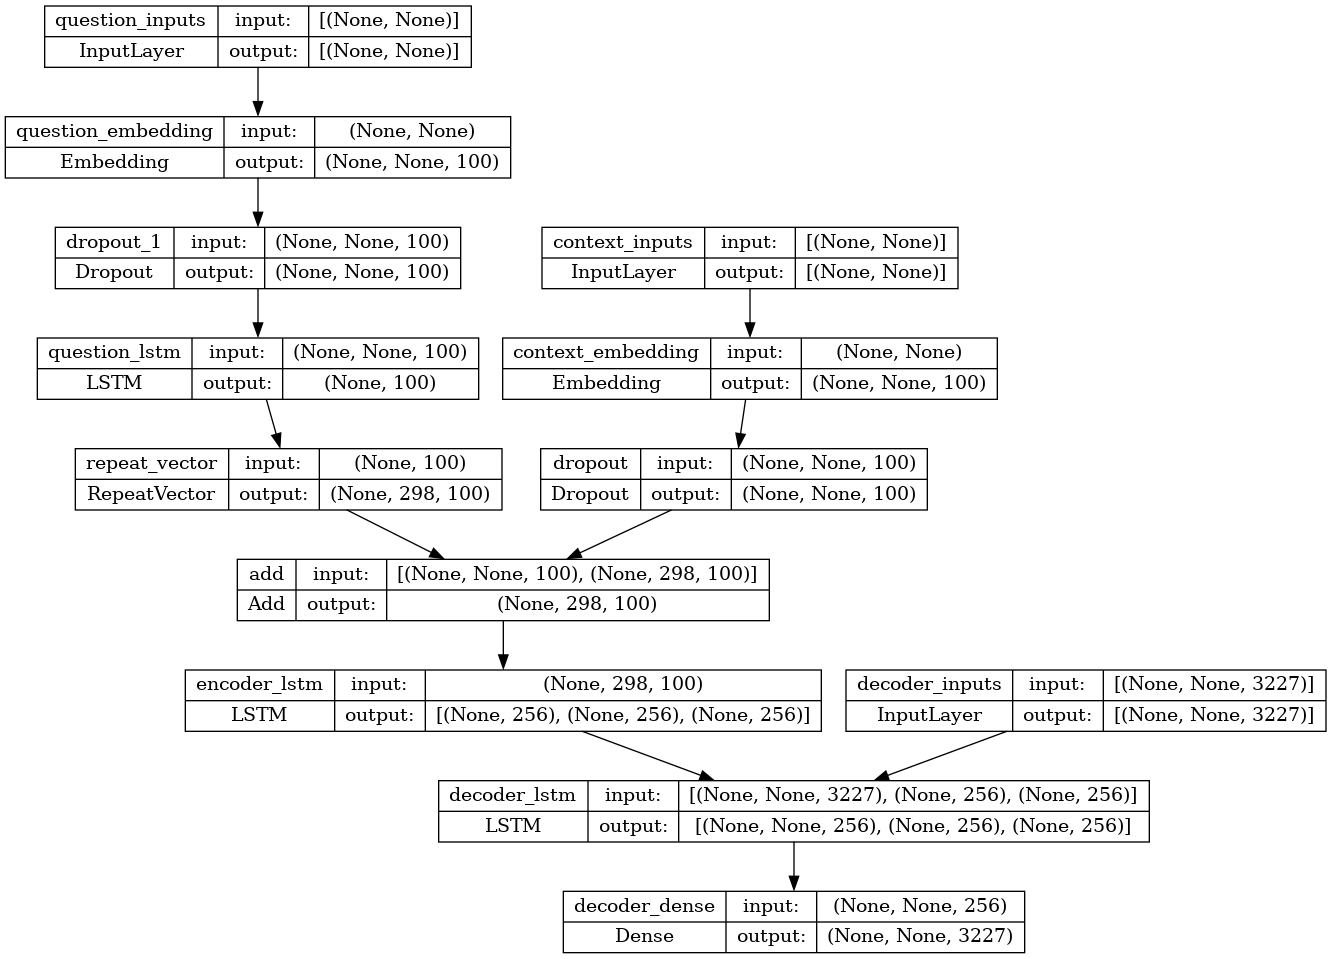

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [16]:
# Defining a helper function to save the model after each epoch 
# in which the loss decreases 
filepath = 'model_QandA.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# Defining a helper function to reduce the learning rate each time 
# the learning plateaus 
reduce_alpha = ReduceLROnPlateau(monitor ='val_loss', factor = 0.2, patience = 1, min_lr = 0.001)
# stop traning if there increase in loss
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
callbacks = [es, checkpoint, reduce_alpha] 

In [17]:
model.fit_generator(generator=train_gen, steps_per_epoch=train_num_batches,
                                           epochs=epochs,
                                           verbose=1, validation_data=test_gen, validation_steps=test_num_batches,
                                           callbacks=callbacks)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/200
29/29 [==============================] - ETA: 0s - loss: 0.9303 - accuracy: 0.0265
Epoch 1: val_loss improved from inf to 0.86371, saving model to model_QandA.h5
29/29 [==============================] - 22s 356ms/step - loss: 0.9303 - accuracy: 0.0265 - val_loss: 0.8637 - val_accuracy: 0.0278 - lr: 0.0010
Epoch 2/200
29/29 [==============================] - ETA: 0s - loss: 0.7540 - accuracy: 0.0278
Epoch 2: val_loss improved from 0.86371 to 0.75751, saving model to model_QandA.h5
29/29 [==============================] - 4s 133ms/step - loss: 0.7540 - accuracy: 0.0278 - val_loss: 0.7575 - val_accuracy: 0.0278 - lr: 0.0010
Epoch 3/200
29/29 [==============================] - ETA: 0s - loss: 0.7414 - accuracy: 0.0278
Epoch 3: val_loss did not improve from 0.75751
29/29 [==============================] - 3s 101ms/step - loss: 0.7414 - accuracy: 0.0278 - val_loss: 0.7611 - val_accuracy: 0.0278 - lr: 0.0010
Epoch 4/200
29/29 [==============================] - ETA: 0s - loss: 0.74

In [18]:
# Test the model
def reply(paragraph, question):
    input_paragraph_seq = []
    input_question_seq = []
    input_paragraph_wid_list = []
    input_question_wid_list = []
    input_paragraph_text = paragraph.lower()
    input_question_text = question.lower()
    for word in nltk.word_tokenize(input_paragraph_text):
        if not in_white_list(word):
            continue
        idx = 1  # default [UNK]
        if word in input_paragraph_word2idx:
            idx = input_paragraph_word2idx[word]
        input_paragraph_wid_list.append(idx)
    for word in nltk.word_tokenize(input_question_text):
        if not in_white_list(word):
            continue
            idx = 1  # default [UNK]
        if word in input_question_word2idx:
            idx = input_question_word2idx[word]
        input_question_wid_list.append(idx)
    input_paragraph_seq.append(input_paragraph_wid_list)
    input_question_seq.append(input_question_wid_list)

    input_paragraph_seq = pad_sequences(input_paragraph_seq, input_paragraph_max_seq_length)
    input_question_seq = pad_sequences(input_question_seq, input_question_max_seq_length)
    states_value = encoder_model.predict([input_paragraph_seq, input_question_seq])

    target_seq = np.zeros((1, 1, num_target_tokens))
    target_seq[0, 0, target_word2idx['START']] = 1
    target_text = ''
    target_text_len = 0
    terminated = False
    while not terminated:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        sample_token_idx = np.argmax(output_tokens[0, -1, :])
        sample_word = target_idx2word[sample_token_idx]
        target_text_len += 1

        if sample_word != 'START' and sample_word != 'END':
            target_text += ' ' + sample_word

        if sample_word == 'END' or target_text_len >= target_max_seq_length:
            terminated = True

        target_seq = np.zeros((1, 1, num_target_tokens))
        target_seq[0, 0, sample_token_idx] = 1

        states_value = [h, c]
    return target_text.strip()

Conclusion
----------

Here I have tried to follow the approach mentioned in https://github.com/scionoftech/Question_Answering_System/blob/master/Question_and_Answer_System.ipynb.
This is still in "Work in Progress" status. The accuracy of this model is not up to the mark. I will continue to explore more on this.